In [13]:

# Default locations if parameter not passed
benchmark_data_path = "tb-compare.pkl"


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
import re
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [15]:
bench_names = df["name"].unique()
print(f"Benchmarks found: {bench_names}")
run_metadata = benchmark_data["config"].applications
n_runs = benchmark_data["config"].metadata.runs

df_bench = df[df["name"] == 'tb-compare']


print(df_bench.columns)
print(df_bench.head())


Benchmarks found: ['tb-compare']
Index(['name', 'node_count', 'iter', 'image', 'full_output', 'hosts',
       'ompc_tb_iter_num', 'type', 'tb_path', 'time'],
      dtype='object')
         name  node_count   iter               image  \
0  tb-compare           1   1000  scheduler-main.sif   
1  tb-compare           1   1000  scheduler-main.sif   
2  tb-compare           1  10000  scheduler-main.sif   
3  tb-compare           1  10000  scheduler-main.sif   
4  tb-compare           2   1000  scheduler-main.sif   

                                         full_output  \
0  [1749737225.509686] [sorgan-cpu1:321788:0]    ...   
1  [1749737226.241517] [sorgan-cpu1:321902:0]    ...   
2  [1749737226.965344] [sorgan-cpu1:322019:0]    ...   
3  [1749737227.692036] [sorgan-cpu1:322137:0]    ...   
4  [1749737228.422309] [sorgan-cpu1:322254:0]    ...   

                                             hosts  ompc_tb_iter_num type  \
0  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4                10 

In [16]:
# print the field full_output of the first row
print("Full output of the first row:")

# tb_time field (seconds)
# get total time from the output
def extract_elapsed_time(text):
    matches = re.findall(r"Elapsed Time ([\d.eE+-]+) seconds", text)
    if matches:
        # gets last mach
        # float() already handles scientific notation
        return float(matches[-1])
    return float('nan')

def extract_total_sched_time(text):
    # Find all "Scheduling : <number>"
    matches = re.findall(r"Scheduling\s*:\s*(\d+)", text)
    if not matches:
        return None
    total_microseconds = sum(int(m) for m in matches)
    return total_microseconds / 1e6  # microseconds to seconds

df_bench['tb_time'] = df_bench['full_output'].apply(extract_elapsed_time)
df_bench['sched_time'] = df_bench['full_output'].apply(extract_total_sched_time)

print(df_bench.columns)



Full output of the first row:
Index(['name', 'node_count', 'iter', 'image', 'full_output', 'hosts',
       'ompc_tb_iter_num', 'type', 'tb_path', 'time', 'tb_time', 'sched_time'],
      dtype='object')


In [17]:
import numpy as np
import pandas as pd

# 1) Bootstrap helpers
def bootstrap_lower(x, n_boot=1000, ci=95):
    boots = np.random.choice(x, (n_boot, len(x)), replace=True).mean(axis=1)
    return np.percentile(boots, (100 - ci) / 2)

def bootstrap_upper(x, n_boot=1000, ci=95):
    boots = np.random.choice(x, (n_boot, len(x)), replace=True).mean(axis=1)
    return np.percentile(boots, 100 - (100 - ci) / 2)

# 2) Your grouping keys
group_fields = [
    'name', 'node_count', 'iter',
    'ompc_tb_iter_num', 'image', 'type', 'tb_path'
]

# 3) Named aggregation—no level_7, straight to mean/CI columns
df_summary = (
    df_bench
    .groupby(group_fields)
    .agg(
        tb_time_mean     = ('tb_time',    'mean'),
        tb_time_ci_lower = ('tb_time',    bootstrap_lower),
        tb_time_ci_upper = ('tb_time',    bootstrap_upper),

        sched_time_mean     = ('sched_time',    'mean'),
        sched_time_ci_lower = ('sched_time',    bootstrap_lower),
        sched_time_ci_upper = ('sched_time',    bootstrap_upper),
    )
    .reset_index()
)

print(df_summary.columns.tolist())


['name', 'node_count', 'iter', 'ompc_tb_iter_num', 'image', 'type', 'tb_path', 'tb_time_mean', 'tb_time_ci_lower', 'tb_time_ci_upper', 'sched_time_mean', 'sched_time_ci_lower', 'sched_time_ci_upper']


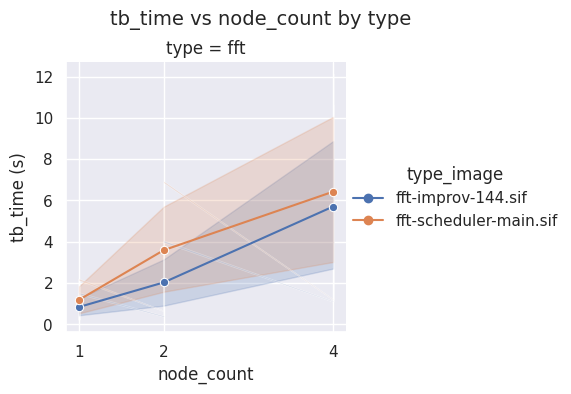

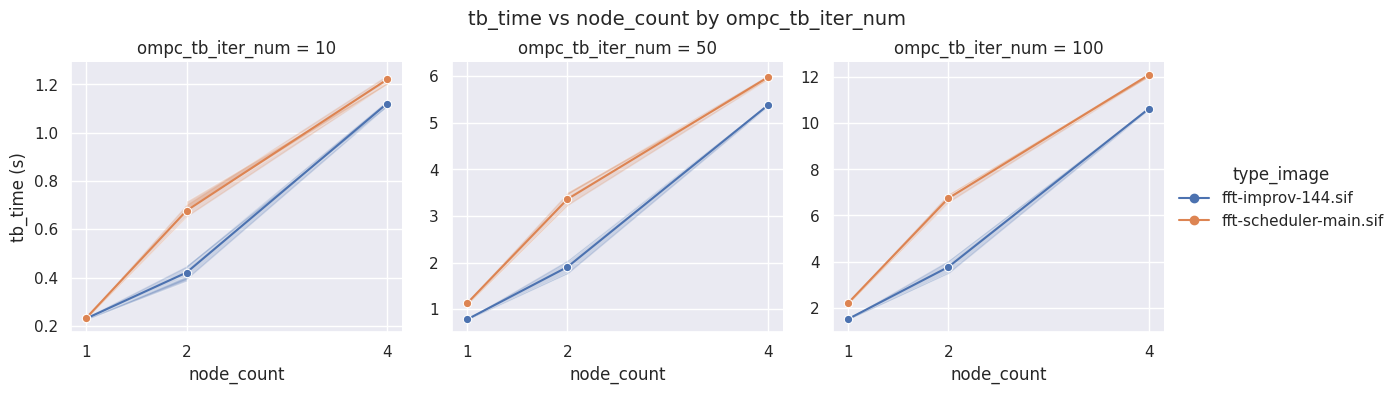

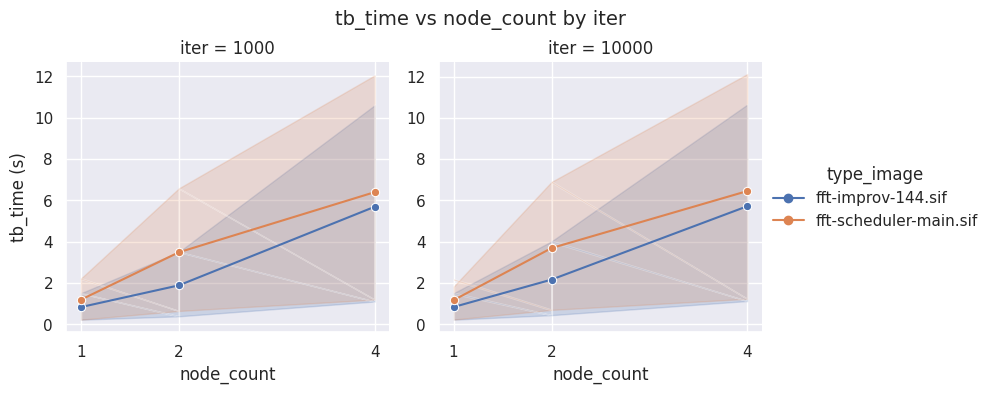

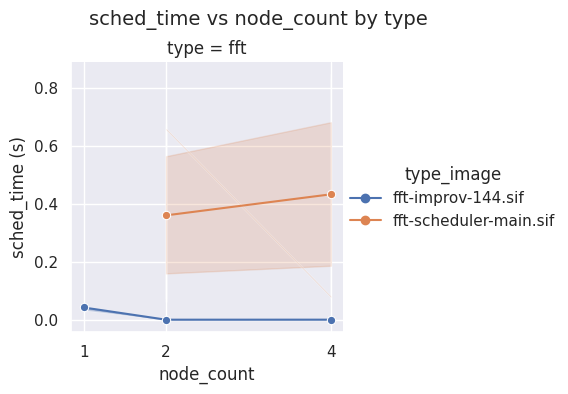

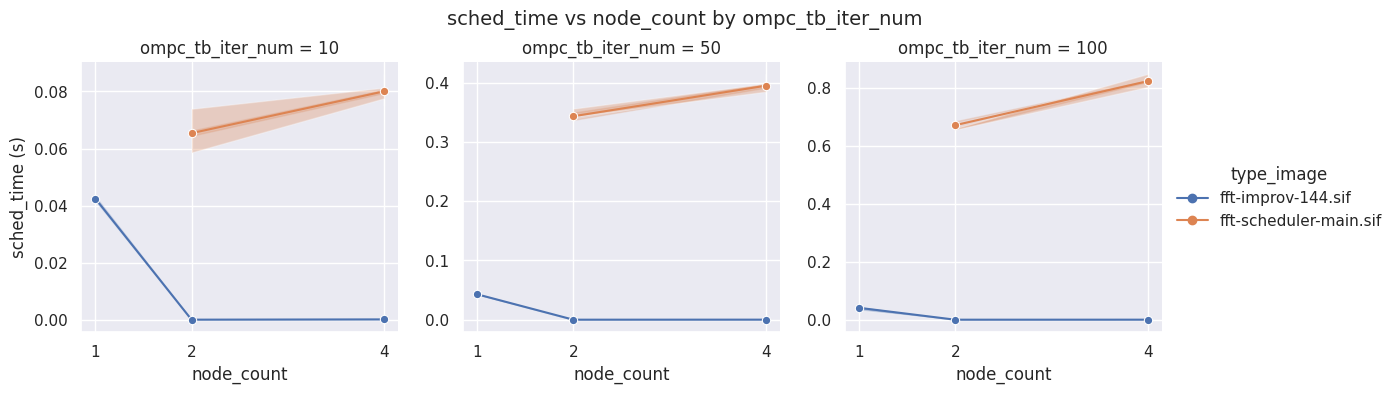

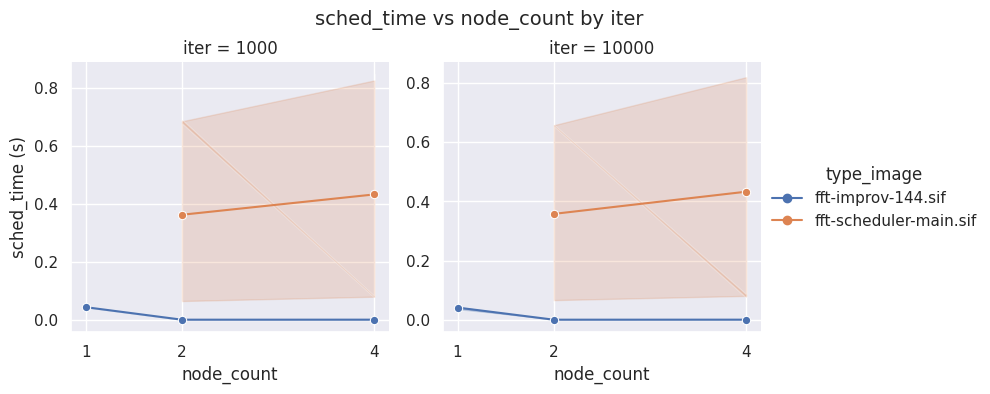

In [20]:
df_summary['type_image'] = df_summary['type'] + '-' + df_summary['image']

metrics = ['tb_time', 'sched_time']
facet_vars = ['type', 'ompc_tb_iter_num', 'iter']

for metric in metrics:
    for facet in facet_vars:
        g = sns.relplot(
            data=df_summary,
            x='node_count',
            y=f'{metric}_mean',
            kind='line',
            hue='type_image',
            col=facet,
            marker='o',
            facet_kws={'sharey': False},
            legend='full',
            height=4,
            aspect=1
        )

        # Overlay CI ribbons
        for ax, facet_val in zip(g.axes.flat, g.col_names):
            sub = df_summary[df_summary[facet] == facet_val]
            for label_val in sub['type_image'].unique():
                sub2 = sub[sub['type_image'] == label_val]
                ax.fill_between(
                    sub2['node_count'],
                    sub2[f'{metric}_ci_lower'],
                    sub2[f'{metric}_ci_upper'],
                    alpha=0.3
                )
        ax.set_xticks(sorted(sub2['node_count'].unique()))
        g.set_axis_labels('node_count', f'{metric} (s)')
        g.fig.subplots_adjust(top=0.85)
        g.fig.suptitle(f'{metric} vs node_count by {facet}', fontsize=14)
        plt.show()
